In [1]:
%matplotlib inline

In [57]:
import pandas as pd
import numpy as np
from scipy.stats import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nb

In [3]:
df_kim = pd.read_csv("/home/julia/workspace/rodent_gradients/interneurons.csv", header=1)

In [4]:
df_julia = pd.read_csv('/home/julia/workspace/rodent_gradients/finest_regions.csv')

### Remove regions that are contained in others in Kim (should be cleaner eventually to combine)

In [5]:
regions = list(df_julia['acronym'])
regions.remove('VISa')
regions.remove('VISli')
regions.remove('VISpor')
regions.remove('VISrl')
regions.remove('SSp-un')

### Add interneuron values to my df

In [6]:
df_julia['PV avg'] = np.nan
df_julia['PV sdv'] = np.nan
df_julia['SST avg'] = np.nan
df_julia['SST sdv'] = np.nan
df_julia['VIP avg'] = np.nan
df_julia['VIP sdv'] = np.nan

In [7]:
for r in regions:
    df_julia.loc[df_julia["acronym"]==r, 'PV avg'] = int(df_kim[df_kim["ROI"]==r]['Average'].values[0].replace(u'\xa0', u''))
    df_julia.loc[df_julia["acronym"]==r, 'PV sdv'] = int(df_kim[df_kim["ROI"]==r]['standard deviation'].values[0].replace(u'\xa0', u''))
    df_julia.loc[df_julia["acronym"]==r, 'SST avg'] = int(df_kim[df_kim["ROI"]==r]['Average.1'].values[0].replace(u'\xa0', u''))
    df_julia.loc[df_julia["acronym"]==r, 'SST sdv'] = int(df_kim[df_kim["ROI"]==r]['standard deviation.1'].values[0].replace(u'\xa0', u''))
    df_julia.loc[df_julia["acronym"]==r, 'VIP avg'] = int(df_kim[df_kim["ROI"]==r]['Average.2'].values[0].replace(u'\xa0', u''))
    df_julia.loc[df_julia["acronym"]==r, 'VIP sdv'] = int(df_kim[df_kim["ROI"]==r]['standard deviation.2'].values[0].replace(u'\xa0', u''))

In [8]:
df_julia.head()

,Unnamed: 0,id,acronym,cluster,type,comment,gradient 0,gradient 1,gradient 2,gradient 3,gradient 4,gradient 5,PV avg,PV sdv,SST avg,SST sdv,VIP avg,VIP sdv
0,0,1,MOp,somatomotor,4.0,NaN,-0.035688,-0.015409,0.012742,-0.009173,0.005131,0.006942,47620.0,3819.0,53229.0,2635.0,25854.0,1481.0
1,1,2,MOs,somatomotor,3.0,NaN,0.002507,-0.003847,0.007450,-0.008521,0.016205,0.005453,33318.0,2638.0,37877.0,1967.0,21107.0,1337.0
2,2,3,SSs,somatomotor,3.0,NaN,-0.037188,0.004716,0.006545,0.006152,-0.005469,0.002474,30964.0,1926.0,30323.0,1681.0,12234.0,908.0
3,3,4,AUDd,auditory,3.0,NaN,0.027084,-0.008822,-0.010148,0.021375,-0.004731,0.020351,11776.0,833.0,11516.0,767.0,5456.0,460.0
4,4,5,AUDp,auditory,4.0,NaN,0.023691,-0.015741,-0.027671,0.022430,-0.004649,0.026404,13501.0,826.0,12566.0,691.0,5624.0,560.0


In [9]:
df_analysis = df_julia.drop(columns=['Unnamed: 0', 'comment'])
df_analysis = df_analysis.dropna(axis=0)

In [10]:
for g in range(6):
    for c in ['PV avg', 'SST avg', 'VIP avg']:
        r = stats.spearmanr(df_analysis['gradient %i' %g], df_analysis[c])
        if r[1]<0.01:
            print('Gradient %i, %s:' %(g,c), r)

Gradient 2, PV avg: SpearmanrResult(correlation=0.5614399824926141, pvalue=0.00024508795150468993)
Gradient 2, SST avg: SpearmanrResult(correlation=0.4290403764087975, pvalue=0.007192191167150476)
Gradient 2, VIP avg: SpearmanrResult(correlation=0.446547762337236, pvalue=0.004948839708875168)


In [11]:
for g in range(6):
    r = stats.spearmanr(df_analysis['gradient %i' %g], df_analysis['PV avg'] / (df_analysis['PV avg']+df_analysis['SST avg']))
    if r[1]<0.01:
        print('Gradient %i:' %(g), r)

Gradient 2: SpearmanrResult(correlation=0.4817813765182186, pvalue=0.0021938394583149575)
Gradient 4: SpearmanrResult(correlation=-0.5793850530692637, pvalue=0.00013809463621733832)


### PCA of interneurons

In [12]:
standard_inter = StandardScaler().fit_transform(np.vstack((df_analysis['PV avg'], df_analysis['SST avg'])).T)

In [13]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(standard_inter)

In [14]:
pca.explained_variance_ratio_[:]

array([0.96876985, 0.03123015])

In [15]:
for g in range(6):
    r = stats.spearmanr(df_analysis['gradient %i' %g], pcs[:,0])
    if r[1]<0.01:
        print('Gradient %i:' %(g), r)

Gradient 2: SpearmanrResult(correlation=0.49250465039938723, pvalue=0.001683138661308851)


In [16]:
for g in range(6):
    r = stats.spearmanr(df_analysis['gradient %i' %g], pcs[:,1])
    if r[1]<0.01:
        print('Gradient %i:' %(g), r)

Gradient 4: SpearmanrResult(correlation=0.5518109202319729, pvalue=0.00032903328292198326)


In [17]:
stats.spearmanr(pcs[:,1], (df_analysis['PV avg'] / (df_analysis['PV avg']+df_analysis['SST avg'])))

SpearmanrResult(correlation=-0.7513951198161725, pvalue=5.452128431154193e-08)

In [27]:
df_analysis['PV_SST_PC0'] = pcs[:,0]
df_analysis['PV_SST_PC1'] = pcs[:,1]

In [30]:
df_analysis.to_csv("/home/julia/workspace/rodent_gradients/interneuron_analysis.csv")

In [32]:
df_analysis.head()

,id,acronym,cluster,type,gradient 0,gradient 1,gradient 2,gradient 3,gradient 4,gradient 5,PV avg,PV sdv,SST avg,SST sdv,VIP avg,VIP sdv,PV_SST_PC0,PV_SST_PC1
0,1,MOp,somatomotor,4.0,-0.035688,-0.015409,0.012742,-0.009173,0.005131,0.006942,47620.0,3819.0,53229.0,2635.0,25854.0,1481.0,4.000020,0.549357
1,2,MOs,somatomotor,3.0,0.002507,-0.003847,0.007450,-0.008521,0.016205,0.005453,33318.0,2638.0,37877.0,1967.0,21107.0,1337.0,2.372539,0.357546
2,3,SSs,somatomotor,3.0,-0.037188,0.004716,0.006545,0.006152,-0.005469,0.002474,30964.0,1926.0,30323.0,1681.0,12234.0,908.0,1.806794,0.028101
3,4,AUDd,auditory,3.0,0.027084,-0.008822,-0.010148,0.021375,-0.004731,0.020351,11776.0,833.0,11516.0,767.0,5456.0,460.0,-0.270640,-0.123194
4,5,AUDp,auditory,4.0,0.023691,-0.015741,-0.027671,0.022430,-0.004649,0.026404,13501.0,826.0,12566.0,691.0,5624.0,560.0,-0.121845,-0.147558


### Plotting

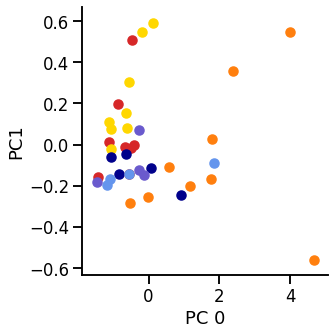

In [43]:
clusters = ['somatomotor', 'prefrontal','lateral', 'medial', 'visual', 'auditory']
colors = ['tab:orange', 'tab:red', 'gold', 'darkblue','cornflowerblue','slateblue']
sns.set_context('talk')
fig = plt.figure(figsize=(5,5))

for c in range(len(clusters)):
    regions = list(df_analysis.loc[df_analysis['cluster']==clusters[c], 'acronym'])
    for r in regions:
        plt.scatter(df_analysis.loc[df_analysis['acronym']==r, 'PV_SST_PC0'].values[0], 
                    df_analysis.loc[df_analysis['acronym']==r, 'PV_SST_PC1'].values[0], 
                    color=colors[c], label=clusters[c])
plt.xlabel('PC 0')
plt.ylabel('PC1')
plt.tight_layout()
sns.despine()

In [44]:
df_analysis.loc[df_analysis['acronym']=='MOp', 'cluster'] = 'motor'
df_analysis.loc[df_analysis['acronym']=='MOs', 'cluster'] = 'motor'
df_analysis.loc[df_analysis['cluster']=='somatomotor', 'cluster'] = 'somatosensory'

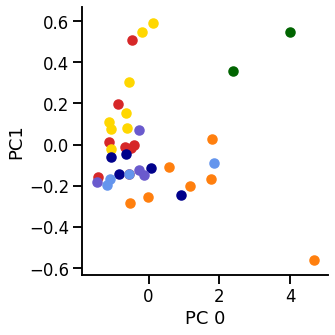

In [46]:
clusters = ['motor', 'somatosensory', 'prefrontal','lateral', 'medial', 'visual', 'auditory']
colors = ['darkgreen', 'tab:orange', 'tab:red', 'gold', 'darkblue','cornflowerblue','slateblue']
sns.set_context('talk')
fig = plt.figure(figsize=(5,5))

for c in range(len(clusters)):
    regions = list(df_analysis.loc[df_analysis['cluster']==clusters[c], 'acronym'])
    for r in regions:
        plt.scatter(df_analysis.loc[df_analysis['acronym']==r, 'PV_SST_PC0'].values[0], 
                    df_analysis.loc[df_analysis['acronym']==r, 'PV_SST_PC1'].values[0], 
                    color=colors[c], label=clusters[c])
plt.xlabel('PC 0')
plt.ylabel('PC1')
plt.tight_layout()
sns.despine()

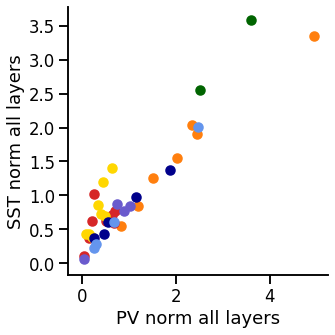

In [55]:
clusters = ['motor', 'somatosensory', 'prefrontal','lateral', 'medial', 'visual', 'auditory']
colors = ['darkgreen', 'tab:orange', 'tab:red', 'gold', 'darkblue','cornflowerblue','slateblue']
sns.set_context('talk')
fig = plt.figure(figsize=(5,5))

pv_norm = np.mean(df_analysis['PV avg'])
sst_norm = np.mean(df_analysis['SST avg'])

for c in range(len(clusters)):
    regions = list(df_analysis.loc[df_analysis['cluster']==clusters[c], 'acronym'])
    for r in regions:
        plt.scatter(df_analysis.loc[df_analysis['acronym']==r, 'PV avg'].values[0] / pv_norm, 
                    df_analysis.loc[df_analysis['acronym']==r, 'SST avg'].values[0] / sst_norm, 
                    color=colors[c], label=clusters[c])
plt.xlabel('PV norm all layers')
plt.ylabel('SST norm all layers')
plt.tight_layout()
sns.despine()

In [83]:
annot_img = nb.load('/home/julia/data/gradients/atlas/allen_api/regions/annot_finest_200um.nii.gz')
annot = np.array(annot_img.get_data(), dtype='float64')

In [77]:
pv_vol = np.zeros_like(annot)
sst_vol = np.zeros_like(annot)
vip_vol = np.zeros_like(annot)

In [78]:
idcs = list(df_analysis['id'])
for idx in idcs:
    pv_vol[annot==idx] = df_analysis.loc[df_analysis['id']==idx]['PV avg'].values[0]
    sst_vol[annot==idx] = df_analysis.loc[df_analysis['id']==idx]['SST avg'].values[0]
    vip_vol[annot==idx] = df_analysis.loc[df_analysis['id']==idx]['VIP avg'].values[0]

In [85]:
nb.save(nb.Nifti1Image(pv_vol, annot_img.affine), "/home/julia/data/gradients/atlas/interneurons/pv_finest.nii.gz")
nb.save(nb.Nifti1Image(sst_vol, annot_img.affine), "/home/julia/data/gradients/atlas/interneurons/sst_finest.nii.gz")
nb.save(nb.Nifti1Image(vip_vol, annot_img.affine), "/home/julia/data/gradients/atlas/interneurons/vip_finest.nii.gz")

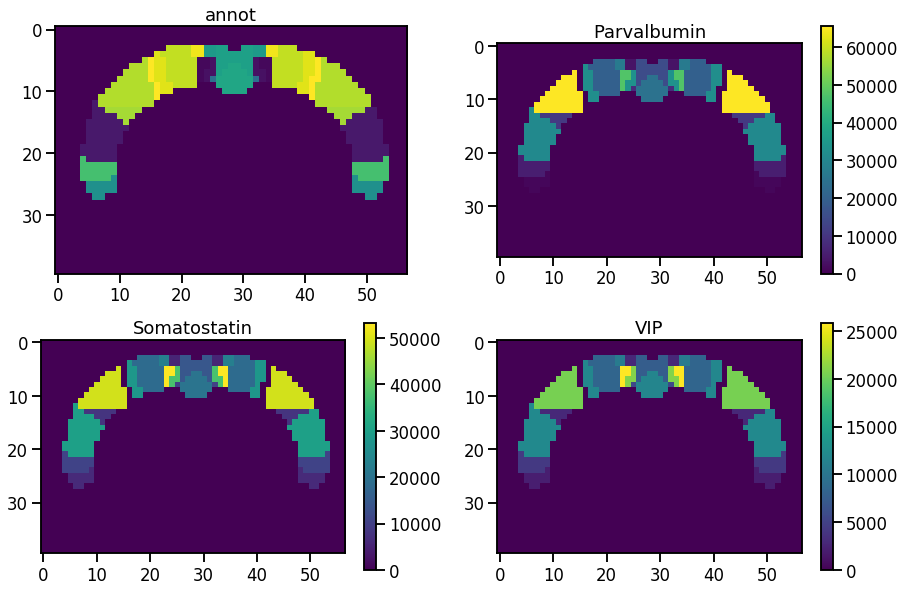

In [82]:
x = 30

fig = plt.figure(figsize=(15,10))
fig.add_subplot(2,2,1)
plt.imshow(annot[x,:,:])
plt.title('annot')
fig.add_subplot(2,2,2)
plt.imshow(pv_vol[x,:,:])
plt.title('Parvalbumin')
plt.colorbar()
fig.add_subplot(2,2,3)
plt.imshow(sst_vol[x,:,:])
plt.title('Somatostatin')
plt.colorbar()
fig.add_subplot(2,2,4)
plt.imshow(vip_vol[x,:,:])
plt.colorbar()
plt.title('VIP');